In [1]:
import numpy as np
import pandas as pd
import time
from datetime import datetime
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from sklearn import preprocessing
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import datetime as dt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV


## Data Reading:

In [2]:
df_consumption = pd.read_csv("updated_new_consumption.csv")

print(df_consumption.shape)
df_consumption.head()

(17034, 50)


,meter_id,date,T1,T2,T3,T4,T5,T6,T7,T8,...,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48
0,0x3efe28fb93c72bebc9cfa41bea027f67ff26470f,2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x3efe28fb93c72bebc9cfa41bea027f67ff26470f,2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0x3efe28fb93c72bebc9cfa41bea027f67ff26470f,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0x3efe28fb93c72bebc9cfa41bea027f67ff26470f,2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0x3efe28fb93c72bebc9cfa41bea027f67ff26470f,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_weather_avg = pd.read_csv("new_weather_avg.csv")

print(df_weather_avg.shape)
df_weather_avg.head()

(51, 366)


,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
0,0x3370de120048d9de744f88357b61d1e8225b0ce5,5.370833,1.529167,3.045833,4.341667,0.670833,1.812500,6.745833,7.691667,6.841667,...,8.612500,7.983333,8.650000,9.841667,4.187500,2.370833,1.1875,1.908333,7.775000,9.270833
1,0xed796ea8cc6535eff1a9afa08a28a096b309b784,5.200000,1.670833,3.300000,5.354167,0.725000,1.450000,6.695833,7.566667,6.670833,...,8.620833,7.983333,9.362500,9.900000,4.108333,2.379167,1.4250,1.670833,7.154167,8.704167
2,0xb9c600842cb2d195d461d675f2758ddbf5bb45bb,4.729167,1.425000,3.475000,4.883333,1.366667,3.095833,7.016667,7.833333,6.891667,...,8.737500,7.908333,9.229167,9.562500,3.695833,1.775000,0.9750,1.758333,6.908333,8.683333
3,0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34,4.458333,1.795833,3.983333,5.070833,1.412500,2.570833,7.262500,7.462500,6.395833,...,8.862500,8.166667,9.275000,9.129167,3.483333,1.433333,1.0750,1.791667,7.175000,8.512500
4,0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e,4.458333,1.795833,3.983333,5.070833,1.412500,2.570833,7.262500,7.462500,6.395833,...,8.862500,8.166667,9.275000,9.129167,3.483333,1.433333,1.0750,1.791667,7.175000,8.512500


In [4]:
df_weather_max = pd.read_csv("new_weather_max.csv")

print(df_weather_max.shape)
df_weather_max.head()

(51, 366)


,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
0,0x3370de120048d9de744f88357b61d1e8225b0ce5,7.3,3.8,5.9,6.6,4.7,4.8,8.0,9.2,8.9,...,10.3,8.8,10.2,10.7,6.1,3.6,3.7,4.4,12.1,12.2
1,0xed796ea8cc6535eff1a9afa08a28a096b309b784,7.4,3.9,6.9,7.2,4.1,5.3,8.1,9.1,9.0,...,10.3,9.0,11.1,11.1,6.4,3.6,4.1,4.9,11.9,11.8
2,0xb9c600842cb2d195d461d675f2758ddbf5bb45bb,7.7,3.6,6.9,7.1,4.3,5.0,8.5,8.5,9.1,...,10.8,8.8,11.0,10.9,5.3,2.8,4.5,4.9,11.3,11.9
3,0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34,7.5,4.4,7.0,7.0,5.8,5.3,9.3,8.8,8.6,...,11.2,9.2,11.2,10.8,5.6,2.7,4.0,5.1,10.8,11.9
4,0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e,7.5,4.4,7.0,7.0,5.8,5.3,9.3,8.8,8.6,...,11.2,9.2,11.2,10.8,5.6,2.7,4.0,5.1,10.8,11.9


In [5]:

df_weather_min = pd.read_csv("new_weather_min.csv")

print(df_weather_min.shape)
df_weather_min.head()

(51, 366)


,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
0,0x3370de120048d9de744f88357b61d1e8225b0ce5,1.3,-0.1,-0.2,1.0,-1.5,-0.7,5.0,6.6,3.1,...,7.2,7.1,7.3,8.7,2.7,0.6,-0.2,-1.5,3.3,6.3
1,0xed796ea8cc6535eff1a9afa08a28a096b309b784,1.3,0.0,-2.0,1.9,-1.3,-2.1,5.3,5.7,3.0,...,4.7,5.4,8.3,6.2,2.9,0.1,-0.7,-3.7,3.0,5.8
2,0xb9c600842cb2d195d461d675f2758ddbf5bb45bb,1.0,0.0,-0.4,1.9,-0.5,-0.6,5.0,7.4,3.5,...,7.2,7.1,8.2,4.8,2.5,-0.5,-2.0,-1.7,2.3,5.5
3,0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34,2.0,-0.1,-0.6,1.4,-0.4,-0.8,4.6,5.6,3.6,...,7.7,7.2,8.0,4.0,2.2,-0.4,-0.8,-2.8,2.8,5.0
4,0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e,2.0,-0.1,-0.6,1.4,-0.4,-0.8,4.6,5.6,3.6,...,7.7,7.2,8.0,4.0,2.2,-0.4,-0.8,-2.8,2.8,5.0


In [6]:
df_addInfo = pd.read_csv("new_addInfo.csv")

print(df_addInfo.shape)
df_addInfo.head()

(51, 24)


,meter_id,dwelling_type,num_occupants,num_bedrooms,heating_fuel,hot_water_fuel,boiler_age,loft_insulation,wall_insulation,heating_temperature,...,refrigerator,tumble_dryer,washing_machine,game_console,laptop,pc,router,set_top_box,tablet,tv
0,0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92,bungalow,2.0,3,gas,gas,new,y,y_cavity,above_20,...,1.0,1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,2
1,0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166,semi_detached_house,2.0,3,gas,gas,new,y,y_cavity,18_to_20,...,1.0,0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,2
2,0x748cad7867e108022b8692e6cf833b2e09efa5df,semi_detached_house,2.0,3,gas,gas,old,y,y_cavity,18_to_20,...,1.0,1,1.0,0.0,1.0,1.0,1.0,1.0,2.0,4
3,0xd1bc7d3545fda93a6a0bacd6c5b5a02005f3d8e1,flat,2.0,1,elec,elec,old,n,not_sure,not_sure,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,0x72ec271fda14656d74e0c2445b80e76f8d194e76,detached_house,2.0,4,gas,gas,new,y,y_cavity,18_to_20,...,2.0,0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,3


# Remove missing from dataset

In [7]:
df_consumption.dropna(inplace=True)
df_weather_avg.dropna(inplace=True)
df_weather_min.dropna(inplace=True)
df_weather_max.dropna(inplace=True)
df_addInfo.dropna(inplace=True)

# Join Datasets

In [8]:
#convert weather df to a joinable format

start = datetime(2017, 1, 1)
end = datetime(2017, 12, 31)
date_range = pd.date_range(start, end)

ed_df_weather_min = pd.DataFrame(columns=["meter_id", "date", "min_temper"])

for meter_idx in tqdm(df_weather_min["meter_id"].values):
    
    df_meter_idx = pd.DataFrame(columns=["meter_id", "date", "min_temper"])
    df_meter_idx["date"] = date_range
    df_meter_idx["meter_id"] = meter_idx
    #print(meter_idx)
    df_meter_idx["min_temper"] = df_weather_min[df_weather_min.meter_id == meter_idx].stack().values[1:].astype(float)

    ed_df_weather_min = pd.concat([ed_df_weather_min, df_meter_idx]).reset_index(drop=True)

ed_df_weather_min = ed_df_weather_min.sort_values(["meter_id", "date"]).reset_index(drop=True)
#df_train["meter_reading"] = df_train["min_temper"]
print(ed_df_weather_min.shape)
ed_df_weather_min.head()


(18250, 3)


,meter_id,date,min_temper
0,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-01,4.5
1,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-02,-0.7
2,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-03,-1.5
3,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-04,0.8
4,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-05,-2.5


In [9]:
ed_df_weather_min["date"] = pd.to_datetime(ed_df_weather_min["date"])
df_consumption["date"] = pd.to_datetime(df_consumption["date"])
df_consumption_min = df_consumption.merge(ed_df_weather_min, on=['meter_id', 'date'], how='left', indicator=False)
df_consumption_min.head()

,meter_id,date,T1,T2,T3,T4,T5,T6,T7,T8,...,T40,T41,T42,T43,T44,T45,T46,T47,T48,min_temper
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0.327,0.494,0.364,0.437,0.434,0.420,0.375,0.288,0.170,6.0
1,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-03,0.149,0.145,0.133,0.128,0.145,0.148,0.131,0.149,...,0.292,0.260,0.239,0.239,0.238,0.245,0.276,0.278,0.197,9.0
2,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-04,0.150,0.133,0.145,0.138,0.124,0.150,0.129,0.152,...,0.977,0.540,0.385,0.351,0.914,0.393,1.119,0.707,0.500,5.0
3,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-05,0.165,0.185,0.204,0.177,0.170,0.184,0.174,0.185,...,0.360,0.299,0.295,0.332,0.318,0.369,0.378,0.272,0.136,0.0
4,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-06,0.151,0.148,0.148,0.139,0.131,0.148,0.144,0.140,...,1.079,0.751,0.571,0.320,0.326,0.321,0.293,0.176,0.148,0.0


In [10]:
#convert weather df to a joinable format

start = datetime(2017, 1, 1)
end = datetime(2017, 12, 31)
date_range = pd.date_range(start, end)

ed_df_weather_max = pd.DataFrame(columns=["meter_id", "date", "max_temper"])

for meter_idx in tqdm(df_weather_max["meter_id"].values):
    
    df_meter_idx = pd.DataFrame(columns=["meter_id", "date", "max_temper"])
    df_meter_idx["date"] = date_range
    df_meter_idx["meter_id"] = meter_idx
    #print(meter_idx)
    df_meter_idx["max_temper"] = df_weather_max[df_weather_max.meter_id == meter_idx].stack().values[1:].astype(float)

    ed_df_weather_max = pd.concat([ed_df_weather_max, df_meter_idx]).reset_index(drop=True)

ed_df_weather_max = ed_df_weather_max.sort_values(["meter_id", "date"]).reset_index(drop=True)
#df_train["meter_reading"] = df_train["min_temper"]
print(ed_df_weather_max.shape)
ed_df_weather_max.head()


(18250, 3)


,meter_id,date,max_temper
0,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-01,9.7
1,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-02,5.4
2,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-03,5.5
3,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-04,7.8
4,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-05,5.3


In [11]:
ed_df_weather_max["date"] = pd.to_datetime(ed_df_weather_max["date"])
df_consumption_min["date"] = pd.to_datetime(df_consumption_min["date"])
df_consumption_min_max = df_consumption_min.merge(ed_df_weather_max, on=['meter_id', 'date'], how='left', indicator=False)
df_consumption_min_max.head()

,meter_id,date,T1,T2,T3,T4,T5,T6,T7,T8,...,T41,T42,T43,T44,T45,T46,T47,T48,min_temper,max_temper
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0.494,0.364,0.437,0.434,0.420,0.375,0.288,0.170,6.0,11.0
1,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-03,0.149,0.145,0.133,0.128,0.145,0.148,0.131,0.149,...,0.260,0.239,0.239,0.238,0.245,0.276,0.278,0.197,9.0,12.0
2,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-04,0.150,0.133,0.145,0.138,0.124,0.150,0.129,0.152,...,0.540,0.385,0.351,0.914,0.393,1.119,0.707,0.500,5.0,11.0
3,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-05,0.165,0.185,0.204,0.177,0.170,0.184,0.174,0.185,...,0.299,0.295,0.332,0.318,0.369,0.378,0.272,0.136,0.0,9.0
4,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-06,0.151,0.148,0.148,0.139,0.131,0.148,0.144,0.140,...,0.751,0.571,0.320,0.326,0.321,0.293,0.176,0.148,0.0,10.0


In [12]:
#convert weather df to a joinable format

start = datetime(2017, 1, 1)
end = datetime(2017, 12, 31)
date_range = pd.date_range(start, end)

ed_df_weather_avg = pd.DataFrame(columns=["meter_id", "date", "avg_temper"])

for meter_idx in tqdm(df_weather_avg["meter_id"].values):
    
    df_meter_idx = pd.DataFrame(columns=["meter_id", "date", "avg_temper"])
    df_meter_idx["date"] = date_range
    df_meter_idx["meter_id"] = meter_idx
    #print(meter_idx)
    df_meter_idx["avg_temper"] = df_weather_avg[df_weather_avg.meter_id == meter_idx].stack().values[1:].astype(float)

    ed_df_weather_avg = pd.concat([ed_df_weather_avg, df_meter_idx]).reset_index(drop=True)

ed_df_weather_avg = ed_df_weather_avg.sort_values(["meter_id", "date"]).reset_index(drop=True)
#df_train["meter_reading"] = df_train["min_temper"]
print(ed_df_weather_avg.shape)
ed_df_weather_avg.head()


(18250, 3)


,meter_id,date,avg_temper
0,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-01,6.350000
1,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-02,2.604167
2,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-03,1.704167
3,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-04,4.745833
4,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-05,0.145833


In [13]:
ed_df_weather_avg["date"] = pd.to_datetime(ed_df_weather_avg["date"])
df_consumption_min_max["date"] = pd.to_datetime(df_consumption_min_max["date"])
df_consumption_min_max_avg = df_consumption_min_max.merge(ed_df_weather_avg, on=['meter_id', 'date'], how='left', indicator=False)
df_consumption_min_max_avg

,meter_id,date,T1,T2,T3,T4,T5,T6,T7,T8,...,T42,T43,T44,T45,T46,T47,T48,min_temper,max_temper,avg_temper
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0.364,0.437,0.434,0.420,0.375,0.288,0.170,6.0,11.0,8.304348
1,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-03,0.149,0.145,0.133,0.128,0.145,0.148,0.131,0.149,...,0.239,0.239,0.238,0.245,0.276,0.278,0.197,9.0,12.0,9.708333
2,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-04,0.150,0.133,0.145,0.138,0.124,0.150,0.129,0.152,...,0.385,0.351,0.914,0.393,1.119,0.707,0.500,5.0,11.0,8.500000
3,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-05,0.165,0.185,0.204,0.177,0.170,0.184,0.174,0.185,...,0.295,0.332,0.318,0.369,0.378,0.272,0.136,0.0,9.0,4.750000
4,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-06,0.151,0.148,0.148,0.139,0.131,0.148,0.144,0.140,...,0.571,0.320,0.326,0.321,0.293,0.176,0.148,0.0,10.0,5.625000
5,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-07,0.143,0.141,0.145,0.139,0.121,0.148,0.134,0.139,...,0.609,0.587,0.447,0.404,0.327,0.132,0.145,6.0,11.0,8.500000
6,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-08,0.144,0.118,0.165,0.143,0.119,0.147,0.137,0.131,...,0.389,0.406,0.907,0.768,0.826,0.313,0.167,1.0,9.0,4.916667
7,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-09,0.182,0.171,0.181,0.182,0.164,0.170,0.187,0.160,...,0.348,0.437,0.359,0.297,0.188,0.132,0.153,6.0,12.0,8.454545
8,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-10,0.154,0.125,0.155,0.118,0.148,0.137,0.142,0.140,...,0.309,0.291,0.308,0.296,0.265,0.537,0.861,6.0,10.0,7.956522
9,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-11,0.789,0.191,0.182,0.171,0.201,0.186,0.143,0.157,...,0.366,0.320,0.293,0.286,0.278,0.161,0.146,5.0,10.0,6.434783


In [14]:
df_consumption_min_max_avg_info = df_consumption_min_max_avg.merge(df_addInfo, on=['meter_id'], how='left', indicator=False)
df_consumption_min_max_avg_info.head()

,meter_id,date,T1,T2,T3,T4,T5,T6,T7,T8,...,refrigerator,tumble_dryer,washing_machine,game_console,laptop,pc,router,set_top_box,tablet,tv
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4
1,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-03,0.149,0.145,0.133,0.128,0.145,0.148,0.131,0.149,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4
2,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-04,0.150,0.133,0.145,0.138,0.124,0.150,0.129,0.152,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4
3,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-05,0.165,0.185,0.204,0.177,0.170,0.184,0.174,0.185,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4
4,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-06,0.151,0.148,0.148,0.139,0.131,0.148,0.144,0.140,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4


# Data cleaning

### missing values (null_reading)

In [15]:
df_consumption_min_max_avg_info.dropna(inplace=True)

### discarding zero reading consumptions


In [16]:
df_consumption_min_max_avg_info = df_consumption_min_max_avg_info.loc[~((df_consumption_min_max_avg_info['T1'] == 0) | (df_consumption_min_max_avg_info['T2'] == 0) | (df_consumption_min_max_avg_info['T3'] == 0) | (df_consumption_min_max_avg_info['T4'] == 0) | (df_consumption_min_max_avg_info['T5'] == 0) | (df_consumption_min_max_avg_info['T6'] == 0) | (df_consumption_min_max_avg_info['T7'] == 0) | (df_consumption_min_max_avg_info['T8'] == 0) | (df_consumption_min_max_avg_info['T9'] == 0) | (df_consumption_min_max_avg_info['T10'] == 0) | (df_consumption_min_max_avg_info['T11'] == 0) | (df_consumption_min_max_avg_info['T12'] == 0) | (df_consumption_min_max_avg_info['T13'] == 0) | (df_consumption_min_max_avg_info['T14'] == 0) | (df_consumption_min_max_avg_info['T15'] == 0) | (df_consumption_min_max_avg_info['T16'] == 0) | (df_consumption_min_max_avg_info['T17'] == 0) | (df_consumption_min_max_avg_info['T18'] == 0) | (df_consumption_min_max_avg_info['T19'] == 0) | (df_consumption_min_max_avg_info['T20'] == 0) | (df_consumption_min_max_avg_info['T21'] == 0) | (df_consumption_min_max_avg_info['T22'] == 0) | (df_consumption_min_max_avg_info['T23'] == 0) | (df_consumption_min_max_avg_info['T24'] == 0) | (df_consumption_min_max_avg_info['T25'] == 0) | (df_consumption_min_max_avg_info['T26'] == 0) | (df_consumption_min_max_avg_info['T27'] == 0) | (df_consumption_min_max_avg_info['T28'] == 0) | (df_consumption_min_max_avg_info['T29'] == 0) | (df_consumption_min_max_avg_info['T30'] == 0) | (df_consumption_min_max_avg_info['T31'] == 0) | (df_consumption_min_max_avg_info['T32'] == 0) | (df_consumption_min_max_avg_info['T33'] == 0) | (df_consumption_min_max_avg_info['T34'] == 0) | (df_consumption_min_max_avg_info['T35'] == 0) | (df_consumption_min_max_avg_info['T36'] == 0) | (df_consumption_min_max_avg_info['T37'] == 0) | (df_consumption_min_max_avg_info['T38'] == 0) | (df_consumption_min_max_avg_info['T39'] == 0) | (df_consumption_min_max_avg_info['T40'] == 0) | (df_consumption_min_max_avg_info['T41'] == 0) | (df_consumption_min_max_avg_info['T42'] == 0) | (df_consumption_min_max_avg_info['T43'] == 0) | (df_consumption_min_max_avg_info['T44'] == 0) | (df_consumption_min_max_avg_info['T46'] == 0) | (df_consumption_min_max_avg_info['T46'] == 0) | (df_consumption_min_max_avg_info['T47'] == 0) | (df_consumption_min_max_avg_info['T48'] == 0))]


In [17]:
df_consumption_min_max_avg_info.to_csv('df_consumption_min_max_avg_info.csv',index=False)

In [18]:
df_consumption_min_max_avg_info.columns

Index(['meter_id', 'date', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8',
       'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18',
       'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28',
       'T29', 'T30', 'T31', 'T32', 'T33', 'T34', 'T35', 'T36', 'T37', 'T38',
       'T39', 'T40', 'T41', 'T42', 'T43', 'T44', 'T45', 'T46', 'T47', 'T48',
       'min_temper', 'max_temper', 'avg_temper', 'dwelling_type',
       'num_occupants', 'num_bedrooms', 'heating_fuel', 'hot_water_fuel',
       'boiler_age', 'loft_insulation', 'wall_insulation',
       'heating_temperature', 'efficient_lighting_percentage', 'dishwasher',
       'freezer', 'fridge_freezer', 'refrigerator', 'tumble_dryer',
       'washing_machine', 'game_console', 'laptop', 'pc', 'router',
       'set_top_box', 'tablet', 'tv'],
      dtype='object')

### Outliers
There are different methods for finding outliers:   1-box plot  2-z-score

 1-box plot

In [19]:
#####1- box plot: (method1)

#####for each column (e.g T1-T48), example here for T1 

#q_low = df_consumption_min_max_avg_info['T1'].quantile(0.01) 
#q_hi = df_consumption_min_max_avg_info['T1'].quantile(0.99)


#df_consumption_min_max_avg_info = df_consumption_min_max_avg_info[(df_consumption_min_max_avg_info['T1'] < q_hi)  
# & (df_consumption_min_max_avg_info['T1'] > q_low)]




In [20]:
#####1- box plot: (method2)

#####for each column (e.g T1-T48), example here for T1 

#Q1 =  df['T1'].quantile(0.25)
#Q3 = df['T1'].quantile(0.75)
#IQR = Q3 - Q1

#df[(df['T1'] < Q1-1.5*IQR ) | (df['T1'] > Q3+1.5*IQR)]['T1']


2- z-score

In [21]:
df_consumption_min_max_avg_info[(np.abs(stats.zscore(df_consumption_min_max_avg_info.iloc[:,2:51])) < 3)]


,meter_id,date,T1,T2,T3,T4,T5,T6,T7,T8,...,refrigerator,tumble_dryer,washing_machine,game_console,laptop,pc,router,set_top_box,tablet,tv
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,1.0,0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,4


### Transofrmation (Catagorization)

In [22]:
df_consumption_min_max_avg_info= pd.get_dummies(df_consumption_min_max_avg_info, columns=['dwelling_type', 'heating_fuel', 'hot_water_fuel', 'boiler_age', 'loft_insulation', 'wall_insulation', 'heating_temperature', 'efficient_lighting_percentage'], drop_first=True)


In [23]:
df_consumption_min_max_avg_info.columns.values


array(['meter_id', 'date', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8',
       'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17',
       'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26',
       'T27', 'T28', 'T29', 'T30', 'T31', 'T32', 'T33', 'T34', 'T35',
       'T36', 'T37', 'T38', 'T39', 'T40', 'T41', 'T42', 'T43', 'T44',
       'T45', 'T46', 'T47', 'T48', 'min_temper', 'max_temper',
       'avg_temper', 'num_occupants', 'num_bedrooms', 'dishwasher',
       'freezer', 'fridge_freezer', 'refrigerator', 'tumble_dryer',
       'washing_machine', 'game_console', 'laptop', 'pc', 'router',
       'set_top_box', 'tablet', 'tv', 'dwelling_type_detached_house',
       'dwelling_type_flat', 'dwelling_type_semi_detached_house',
       'dwelling_type_terraced_house', 'heating_fuel_gas',
       'heating_fuel_lpg_oil', 'heating_fuel_other', 'hot_water_fuel_gas',
       'hot_water_fuel_other', 'boiler_age_old', 'loft_insulation_y',
       'wall_insulation_not_sure', 'wal

## Feature Engineering

### Creating New Features : Max/Avg/Min of  daily consumption

In [24]:
col = df_consumption_min_max_avg_info.loc[: , "T1":"T48"]
df_consumption_min_max_avg_info['T_mean'] = col.mean(axis=1)
df_consumption_min_max_avg_info['T_max'] = col.max(axis=1)
df_consumption_min_max_avg_info['T_min'] = col.min(axis=1)


In [25]:
df_consumption_min_max_avg_info.head()

,meter_id,date,T1,T2,T3,T4,T5,T6,T7,T8,...,wall_insulation_y_internal,heating_temperature_above_20,heating_temperature_below_18,heating_temperature_not_sure,efficient_lighting_percentage_25_to_50,efficient_lighting_percentage_50_to_75,efficient_lighting_percentage_75_to_100,T_mean,T_max,T_min
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,0,0,0,0,1,0,0.322771,2.467,0.120
1,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-03,0.149,0.145,0.133,0.128,0.145,0.148,0.131,0.149,...,0,0,0,0,0,1,0,0.263771,1.975,0.119
2,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-04,0.150,0.133,0.145,0.138,0.124,0.150,0.129,0.152,...,0,0,0,0,0,1,0,0.402854,2.265,0.112
3,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-05,0.165,0.185,0.204,0.177,0.170,0.184,0.174,0.185,...,0,0,0,0,0,1,0,0.360729,1.253,0.136
4,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-06,0.151,0.148,0.148,0.139,0.131,0.148,0.144,0.140,...,0,0,0,0,0,1,0,0.317062,1.612,0.119


### Adding Next-day Avg/Min/Max Tempreature

In [26]:
#formatting the weathers df

next_ed_df_weather_min = pd.DataFrame(columns=["meter_id", "date", "min_temper", "next_day_min_tempr"])
#18249
for i in tqdm(range(18249)):
    next_ed_df_weather_min.at[i,'meter_id']= ed_df_weather_min.iloc[i][0]
    next_ed_df_weather_min.at[i,'date']= ed_df_weather_min.iloc[i][1]
    next_ed_df_weather_min.at[i,'min_temper']= ed_df_weather_min.iloc[i][2]
    
    if(ed_df_weather_min.iloc[i][0] == ed_df_weather_min.iloc[i+1][0]):
        next_ed_df_weather_min.at[i,'next_day_min_tempr']= ed_df_weather_min.iloc[i+1][2]
    else:
        next_ed_df_weather_min.at[i,'next_day_min_tempr']= None

    
    #print(next_ed_df_weather_min)

        
next_ed_df_weather_min.head()

,meter_id,date,min_temper,next_day_min_tempr
0,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-01 00:00:00,4.5,-0.7
1,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-02 00:00:00,-0.7,-1.5
2,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-03 00:00:00,-1.5,0.8
3,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-04 00:00:00,0.8,-2.5
4,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-05 00:00:00,-2.5,-2.4


In [27]:
del next_ed_df_weather_min['min_temper']
next_ed_df_weather_min["date"] = pd.to_datetime(next_ed_df_weather_min["date"])
df_consumption_min_max_avg_info["date"] = pd.to_datetime(df_consumption_min_max_avg_info["date"])
df_consumption_min_max_avg_info_1 = df_consumption_min_max_avg_info.merge(next_ed_df_weather_min, on=['meter_id', 'date'], how='left', indicator=False)


In [28]:
next_ed_df_weather_max = pd.DataFrame(columns=["meter_id", "date", "max_temper", "next_day_max_tempr"])
#18249
for i in tqdm(range(18249)):
    next_ed_df_weather_max.at[i,'meter_id']= ed_df_weather_max.iloc[i][0]
    next_ed_df_weather_max.at[i,'date']= ed_df_weather_max.iloc[i][1]
    next_ed_df_weather_max.at[i,'max_temper']= ed_df_weather_max.iloc[i][2]
    
    if(ed_df_weather_max.iloc[i][0] == ed_df_weather_max.iloc[i+1][0]):
        next_ed_df_weather_max.at[i,'next_day_max_tempr']= ed_df_weather_max.iloc[i+1][2]
    else:
        next_ed_df_weather_max.at[i,'next_day_max_tempr']= None

    
    #print(next_ed_df_weather_max)

        
next_ed_df_weather_max.head()

,meter_id,date,max_temper,next_day_max_tempr
0,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-01 00:00:00,9.7,5.4
1,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-02 00:00:00,5.4,5.5
2,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-03 00:00:00,5.5,7.8
3,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-04 00:00:00,7.8,5.3
4,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-05 00:00:00,5.3,6.7


In [29]:
del next_ed_df_weather_max['max_temper']
next_ed_df_weather_max["date"] = pd.to_datetime(next_ed_df_weather_max["date"])
df_consumption_min_max_avg_info_1["date"] = pd.to_datetime(df_consumption_min_max_avg_info_1["date"])
df_consumption_min_max_avg_info_12 = df_consumption_min_max_avg_info_1.merge(next_ed_df_weather_max, on=['meter_id', 'date'], how='left', indicator=False)


In [30]:
next_ed_df_weather_avg = pd.DataFrame(columns=["meter_id", "date", "avg_temper", "next_day_avg_tempr"])
#18249
for i in tqdm(range(18249)):
    next_ed_df_weather_avg.at[i,'meter_id']= ed_df_weather_avg.iloc[i][0]
    next_ed_df_weather_avg.at[i,'date']= ed_df_weather_avg.iloc[i][1]
    next_ed_df_weather_avg.at[i,'avg_temper']= ed_df_weather_avg.iloc[i][2]
    
    if(ed_df_weather_avg.iloc[i][0] == ed_df_weather_avg.iloc[i+1][0]):
        next_ed_df_weather_avg.at[i,'next_day_avg_tempr']= ed_df_weather_avg.iloc[i+1][2]
    else:
        next_ed_df_weather_avg.at[i,'next_day_avg_tempr']= None

    
    #print(next_ed_df_weather_avg)

        
next_ed_df_weather_avg.head()

,meter_id,date,avg_temper,next_day_avg_tempr
0,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-01 00:00:00,6.35,2.60417
1,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-02 00:00:00,2.60417,1.70417
2,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-03 00:00:00,1.70417,4.74583
3,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-04 00:00:00,4.74583,0.145833
4,0x067ae210f71a5fe0e54032b3506fc4b37e44e622,2017-01-05 00:00:00,0.145833,2.25833


In [31]:
del next_ed_df_weather_avg['avg_temper']
next_ed_df_weather_avg["date"] = pd.to_datetime(next_ed_df_weather_avg["date"])
df_consumption_min_max_avg_info_12["date"] = pd.to_datetime(df_consumption_min_max_avg_info_12["date"])
df_consumption_min_max_avg_info_123 = df_consumption_min_max_avg_info_12.merge(next_ed_df_weather_avg, on=['meter_id', 'date'], how='left', indicator=False)
df_consumption_min_max_avg_info_123.head()

,meter_id,date,T1,T2,T3,T4,T5,T6,T7,T8,...,heating_temperature_not_sure,efficient_lighting_percentage_25_to_50,efficient_lighting_percentage_50_to_75,efficient_lighting_percentage_75_to_100,T_mean,T_max,T_min,next_day_min_tempr,next_day_max_tempr,next_day_avg_tempr
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,0,1,0,0.322771,2.467,0.120,9,12,9.70833
1,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-03,0.149,0.145,0.133,0.128,0.145,0.148,0.131,0.149,...,0,0,1,0,0.263771,1.975,0.119,5,11,8.5
2,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-04,0.150,0.133,0.145,0.138,0.124,0.150,0.129,0.152,...,0,0,1,0,0.402854,2.265,0.112,0,9,4.75
3,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-05,0.165,0.185,0.204,0.177,0.170,0.184,0.174,0.185,...,0,0,1,0,0.360729,1.253,0.136,0,10,5.625
4,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-06,0.151,0.148,0.148,0.139,0.131,0.148,0.144,0.140,...,0,0,1,0,0.317062,1.612,0.119,6,11,8.5


# Adding Y class (next_day_max_consumption)

In [32]:
df_consumption_min_max_avg_info_123_Y = df_consumption_min_max_avg_info_123
df_consumption_min_max_avg_info_123_Y ["Y_next_day_max_consumption"]=None
#df_consumption_min_max_avg_info_123_Y

In [33]:
df_consumption_min_max_avg_info_123.shape

(6803, 96)

In [34]:
#df_consumption_min_max_avg_info_123.columns

In [35]:
for i in tqdm(range(6801)):
    
    if(df_consumption_min_max_avg_info_123.iloc[i][0] == df_consumption_min_max_avg_info_123.iloc[i+1][0]):
        print(df_consumption_min_max_avg_info_123.iloc[i][0])
        #print("yes")
                #print("yes")

        df_consumption_min_max_avg_info_123_Y.at[i,'Y_next_day_max_consumption']= df_consumption_min_max_avg_info_123.iloc[i+1][90]
        
df_consumption_min_max_avg_info_123_Y.head()

0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c
0xf4fe2245b

0x4f33c31f9d872870123d24fd1e4ae67bc230e561
0x4f33c31f9d872870123d24fd1e4ae67bc230e561
0x4f33c31f9d872870123d24fd1e4ae67bc230e561
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8cc6535eff1a9afa08a28a096b309b784
0xed796ea8c

0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81756e70e315c767d2181b46fb01a6bf2
0x455050a81

0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9685df3c4c5188d6e74b6d90a7dbf166
0xd030a4ef9

0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f71a5fe0e54032b3506fc4b37e44e622
0x067ae210f

0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d00faaca917d563ad75646ce6860700b4
0x50626a5d0

0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b266d53d705137593347cee145571eda8
0xbfabb20b2

0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5dfaa32d4f2f095424effd031420a7acfc
0xc41d1a5df

0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xebecc401efc70f783c60d6ba1c11a198474f42ad
0xb9c600842cb2d195d461d675f2758ddbf5bb45bb
0xb9c600842cb2d195d461d675f2758ddbf5bb45bb
0xb9c600842cb2d195d461d675f2758ddbf5bb45bb
0xb9c600842cb2d195d461d675f2758ddbf5bb45bb
0xb9c600842cb2d195d461d675f2758ddbf5bb45bb
0xb9c600842cb2d195d461d675f2758ddbf5bb45bb
0xb9c600842cb2d195d461d675f2758ddbf5bb45bb
0xb9c600842

0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527aff4b4b8035e960c5eaaf848e7c8c92
0xbae5a5527

0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed1576f9ff919eef8a8aed16b72f0a9f96c
0x8f8cfed15

0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c096010e49d9d31ab9135a6251bab8780810
0x22a8c0960

0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4b4622631518e6c6140a89d23f5ecb81
0xf99426ae4

0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd4404395f8d1088ea53b9a83d7e55ef8d6e
0x9149cd440

0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010767f6e76099868901c144906d72075a
0x9c2767010

0x9c2767010767f6e76099868901c144906d72075a
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad786

0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad7867e108022b8692e6cf833b2e09efa5df
0x748cad786

0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0168665ab1ae64ae171b776cb16952fc
0x81886afb0

0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120048d9de744f88357b61d1e8225b0ce5
0x3370de120

0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
0x0a68e0f81

0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8b65d2422f96839008b40404914b16fe
0x7cc8143a8

0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732

0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0x1e1863732354a2789ae9f9503ee8af99b10d05e8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd02460624

0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd024606242f8beffc680b1cac51625ccfd606cc8
0xd02460624

0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d94864ae2fcd1fe5ee6222921a32bacb
0xfb1b12b0d

0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372

0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372c45642d17b6aad6f5057b919bcdfe4c
0x94ace0372

0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e62a3e9dd846cf2a50aca353586f8f947
0x69da784e6

0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5

0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
0xe4f787cb5

0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd87a4b945e0d262aec41e0eb2b59fe1e
0x78a812ecd

0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7

0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7244992f10bbb688593acee69df6ec19
0xa00abe9e7

0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3e6902d809a148ee17934c3c2c21888d
0xa915749f3

0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f

0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68
0xcd61d0e2f

,meter_id,date,T1,T2,T3,T4,T5,T6,T7,T8,...,efficient_lighting_percentage_25_to_50,efficient_lighting_percentage_50_to_75,efficient_lighting_percentage_75_to_100,T_mean,T_max,T_min,next_day_min_tempr,next_day_max_tempr,next_day_avg_tempr,Y_next_day_max_consumption
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9,12,9.70833,1.975
1,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-03,0.149,0.145,0.133,0.128,0.145,0.148,0.131,0.149,...,0,1,0,0.263771,1.975,0.119,5,11,8.5,2.265
2,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-04,0.150,0.133,0.145,0.138,0.124,0.150,0.129,0.152,...,0,1,0,0.402854,2.265,0.112,0,9,4.75,1.253
3,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-05,0.165,0.185,0.204,0.177,0.170,0.184,0.174,0.185,...,0,1,0,0.360729,1.253,0.136,0,10,5.625,1.612
4,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-06,0.151,0.148,0.148,0.139,0.131,0.148,0.144,0.140,...,0,1,0,0.317062,1.612,0.119,6,11,8.5,2.254


In [36]:
#df_consumption_min_max_avg_info_123_Y.to_csv('df_consumption_min_max_avg_info_123_Y.csv',index=False)

# Outliers


In [37]:
df_consumption_min_max_avg_info_123_Y[(np.abs(stats.zscore(df_consumption_min_max_avg_info_123_Y.iloc[:,2:51])) < 3)]


,meter_id,date,T1,T2,T3,T4,T5,T6,T7,T8,...,efficient_lighting_percentage_25_to_50,efficient_lighting_percentage_50_to_75,efficient_lighting_percentage_75_to_100,T_mean,T_max,T_min,next_day_min_tempr,next_day_max_tempr,next_day_avg_tempr,Y_next_day_max_consumption
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9,12,9.70833,1.975
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9,12,9.70833,1.975
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9,12,9.70833,1.975
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9,12,9.70833,1.975
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9,12,9.70833,1.975
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9,12,9.70833,1.975
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9,12,9.70833,1.975
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9,12,9.70833,1.975
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9,12,9.70833,1.975
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9,12,9.70833,1.975


In [38]:
#df_consumption_min_max_avg_info_123_Y = np.array(df_consumption_min_max_avg_info_123_Y.iloc[:,89:95], dtype=np.float64) # can use np.float32 as well


df_consumption_min_max_avg_info_123_Y.iloc[:, 89] = pd.to_numeric(df_consumption_min_max_avg_info_123_Y.iloc[:, 89])
df_consumption_min_max_avg_info_123_Y.iloc[:, 90] = pd.to_numeric(df_consumption_min_max_avg_info_123_Y.iloc[:, 90])
df_consumption_min_max_avg_info_123_Y.iloc[:, 91] = pd.to_numeric(df_consumption_min_max_avg_info_123_Y.iloc[:, 91])
df_consumption_min_max_avg_info_123_Y.iloc[:, 92] = pd.to_numeric(df_consumption_min_max_avg_info_123_Y.iloc[:, 92])
df_consumption_min_max_avg_info_123_Y.iloc[:, 93] = pd.to_numeric(df_consumption_min_max_avg_info_123_Y.iloc[:, 93])
df_consumption_min_max_avg_info_123_Y.iloc[:, 94] = pd.to_numeric(df_consumption_min_max_avg_info_123_Y.iloc[:, 94])
df_consumption_min_max_avg_info_123_Y.iloc[:, 95] = pd.to_numeric(df_consumption_min_max_avg_info_123_Y.iloc[:, 95])


#df_consumption_min_max_avg_info_123_Y.iloc[:,89:95] = pd.to_numeric(df_consumption_min_max_avg_info_123_Y.iloc[:,89:95])

In [39]:
df_consumption_min_max_avg_info_123_Y[(np.abs(stats.zscore(df_consumption_min_max_avg_info_123_Y.iloc[:,89:95])) < 3)]

,meter_id,date,T1,T2,T3,T4,T5,T6,T7,T8,...,efficient_lighting_percentage_25_to_50,efficient_lighting_percentage_50_to_75,efficient_lighting_percentage_75_to_100,T_mean,T_max,T_min,next_day_min_tempr,next_day_max_tempr,next_day_avg_tempr,Y_next_day_max_consumption
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9.0,12.0,9.708333,1.975
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9.0,12.0,9.708333,1.975
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9.0,12.0,9.708333,1.975
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9.0,12.0,9.708333,1.975
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9.0,12.0,9.708333,1.975
0,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-02,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,...,0,1,0,0.322771,2.467,0.120,9.0,12.0,9.708333,1.975
1,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-03,0.149,0.145,0.133,0.128,0.145,0.148,0.131,0.149,...,0,1,0,0.263771,1.975,0.119,5.0,11.0,8.500000,2.265
1,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-03,0.149,0.145,0.133,0.128,0.145,0.148,0.131,0.149,...,0,1,0,0.263771,1.975,0.119,5.0,11.0,8.500000,2.265
1,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-03,0.149,0.145,0.133,0.128,0.145,0.148,0.131,0.149,...,0,1,0,0.263771,1.975,0.119,5.0,11.0,8.500000,2.265
1,0xf4fe2245bf908cb1bd3201e4fceb97d6d229c60c,2017-11-03,0.149,0.145,0.133,0.128,0.145,0.148,0.131,0.149,...,0,1,0,0.263771,1.975,0.119,5.0,11.0,8.500000,2.265


In [40]:
df_consumption_min_max_avg_info_123_Y.columns


Index(['meter_id', 'date', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8',
       'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18',
       'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28',
       'T29', 'T30', 'T31', 'T32', 'T33', 'T34', 'T35', 'T36', 'T37', 'T38',
       'T39', 'T40', 'T41', 'T42', 'T43', 'T44', 'T45', 'T46', 'T47', 'T48',
       'min_temper', 'max_temper', 'avg_temper', 'num_occupants',
       'num_bedrooms', 'dishwasher', 'freezer', 'fridge_freezer',
       'refrigerator', 'tumble_dryer', 'washing_machine', 'game_console',
       'laptop', 'pc', 'router', 'set_top_box', 'tablet', 'tv',
       'dwelling_type_detached_house', 'dwelling_type_flat',
       'dwelling_type_semi_detached_house', 'dwelling_type_terraced_house',
       'heating_fuel_gas', 'heating_fuel_lpg_oil', 'heating_fuel_other',
       'hot_water_fuel_gas', 'hot_water_fuel_other', 'boiler_age_old',
       'loft_insulation_y', 'wall_insulation_not_sure',
       'wal

# Normalize

In [41]:
#Consumptions
preprocessing.normalize(df_consumption_min_max_avg_info_123_Y.iloc[:,2:51])
preprocessing.normalize(df_consumption_min_max_avg_info_123_Y.iloc[:,89:95])


array([[ 0.01789155,  0.13674855,  0.00665173,  0.49888   ,  0.66517334,
         0.53814371],
       [ 0.0176938 ,  0.13248341,  0.00798254,  0.33540104,  0.73788228,
         0.57018176],
       [ 0.03860989,  0.21707957,  0.01073418,  0.        ,  0.86256784,
         0.45524414],
       ...,
       [ 0.02532356,  0.15829699,  0.00745725,  0.06779314,  0.86436256,
         0.47172728],
       [ 0.03962207,  0.26846998,  0.01075979, -0.393651  ,  0.8397888 ,
         0.25696663],
       [ 0.02524641,  0.23073896,  0.00656979,  0.05972536,  0.85606343,
         0.45789439]])

# Visualization

### Avg daily consumption for a specific customer (meter_id) 0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68

314
314


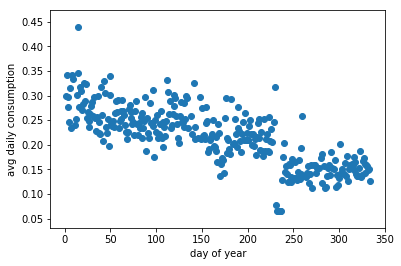

In [42]:
x_cons= df_consumption_min_max_avg_info_123_Y[df_consumption_min_max_avg_info_123_Y.meter_id=='0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68']["date"]
x = list()


for i in x_cons:
    day=i.timetuple().tm_yday
    x.append(day)


print(len(x))

y= df_consumption_min_max_avg_info_123_Y[df_consumption_min_max_avg_info_123_Y.meter_id=='0xcd61d0e2f496d81ddb7d7bd4eab4b1ceb87d2b68']["T_mean"]
y=list(y)
print(len(y))

plt.xlabel("day of year")
plt.ylabel("avg daily consumption")

plt.scatter(x, y)
plt.show()

### Avg daily consumption for all customers during a year

In [43]:
#Calculate Avg
dft=df_consumption_min_max_avg_info_123_Y.groupby(['date']).mean()
dft.shape

(334, 94)

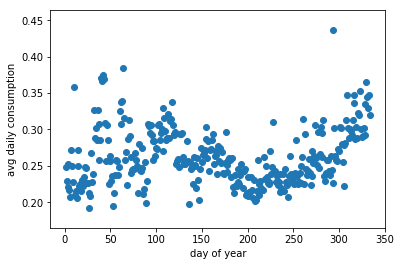

In [44]:
x_cons= dft.index

x= list()
y= list()
for i in x_cons:
    day=i.timetuple().tm_yday
    x.append(day)
    mc=dft.iloc[dft.index==i]['T_mean']
    y.append(mc)
    
plt.xlabel("day of year")
plt.ylabel("avg daily consumption")

plt.scatter(x, y)
plt.show()

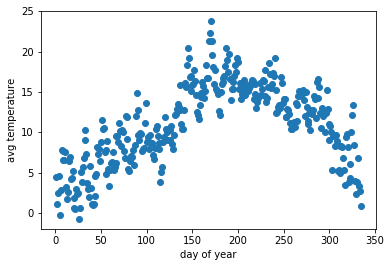

In [45]:
x_cons= dft.index

x= list()
y= list()
for i in x_cons:
    day=i.timetuple().tm_yday
    x.append(day)
    mc=dft.iloc[dft.index==i]['avg_temper']
    y.append(mc)
    
plt.xlabel("day of year")
plt.ylabel("avg temperature")

plt.scatter(x, y)
plt.show()

### omitting missing data for the Y

In [46]:
df_consumption_min_max_avg_info_123_Y.shape

(6803, 96)

In [47]:
df_consumption_min_max_avg_info_123_Y.dropna(inplace=True)

In [48]:
df_consumption_min_max_avg_info_123_Y.shape

(6755, 96)

In [49]:
df_consumption_min_max_avg_info_123_Y.to_csv('fin_df_consumption_min_max_avg_info_123_Y.csv',index=False)

# Experimental setup

#### number of features : 94

In [50]:
df_consumption_min_max_avg_info_123_Y.shape

(6755, 96)

In [51]:
#df_consumption_min_max_avg_info_123_Y.columns

In [52]:
#df_consumption_min_max_avg_info_123_Y
df_consumption_min_max_avg_info_123_Y['date'] = pd.to_datetime(df_consumption_min_max_avg_info_123_Y['date'])
df_consumption_min_max_avg_info_123_Y['date']=df_consumption_min_max_avg_info_123_Y['date'].map(dt.datetime.toordinal)

In [53]:
X= df_consumption_min_max_avg_info_123_Y.iloc[:, 1:94]
X.head()

,date,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,heating_temperature_below_18,heating_temperature_not_sure,efficient_lighting_percentage_25_to_50,efficient_lighting_percentage_50_to_75,efficient_lighting_percentage_75_to_100,T_mean,T_max,T_min,next_day_min_tempr,next_day_max_tempr
0,736635,0.153,0.125,0.161,0.151,0.122,0.145,0.160,0.124,0.154,...,0,0,0,1,0,0.322771,2.467,0.120,9.0,12.0
1,736636,0.149,0.145,0.133,0.128,0.145,0.148,0.131,0.149,0.130,...,0,0,0,1,0,0.263771,1.975,0.119,5.0,11.0
2,736637,0.150,0.133,0.145,0.138,0.124,0.150,0.129,0.152,0.138,...,0,0,0,1,0,0.402854,2.265,0.112,0.0,9.0
3,736638,0.165,0.185,0.204,0.177,0.170,0.184,0.174,0.185,0.191,...,0,0,0,1,0,0.360729,1.253,0.136,0.0,10.0
4,736639,0.151,0.148,0.148,0.139,0.131,0.148,0.144,0.140,0.147,...,0,0,0,1,0,0.317062,1.612,0.119,6.0,11.0


In [54]:
Y= df_consumption_min_max_avg_info_123_Y['Y_next_day_max_consumption']
Y.head()

0    1.975
1    2.265
2    1.253
3    1.612
4    2.254
Name: Y_next_day_max_consumption, dtype: float64

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=0)

## Random Forest

In [56]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [57]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10]}


In [58]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [59]:
rf_random.fit(X_train, y_train)

#rf.fit(X_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   45.3s remaining:   39.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=1000,
                             

In [60]:
#best parameters from fitting the random search

rf_random.best_params_


{'bootstrap': False,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 600}

In [61]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

### Parametes and performance

In [62]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 0.2977 degrees.
Accuracy = 53.26%.


In [63]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.2738 degrees.
Accuracy = 55.48%.


In [64]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 4.16%.


In [65]:
#df_consumption_min_max_avg_info_123_Y.to_csv('My_Final_Preprocessed.csv',index=False)

## Regression

In [66]:
regr = linear_model.LinearRegression()


In [67]:
regr.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
y_pred = regr.predict(X_test)


### Parametes and performance

In [69]:
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [-1.99360961e-04 -1.86536564e-01  1.67643430e-01 -6.20086507e-02
  1.24767961e-01  9.08259859e-02  1.04358511e-01  6.97708053e-02
 -1.00151925e-03 -4.47458353e-02 -2.93537480e-02 -4.26482838e-02
  4.97269110e-03  3.43196636e-02  2.12360102e-02  8.16312954e-02
 -2.05158965e-02  3.00164063e-02  7.40968332e-03 -1.74171087e-02
 -3.36597500e-02 -1.38546104e-02  8.15600535e-02 -1.67005325e-03
 -1.04938711e-02  4.22509177e-02 -6.84042935e-02 -1.61000473e-03
  7.55217205e-02 -9.06816835e-03 -8.05893625e-03 -2.77050471e-02
  1.94180203e-02  2.28182207e-02 -1.18069002e-02  3.88452242e-02
  7.75349204e-02 -3.31740599e-02  3.17258647e-02 -3.97168178e-02
 -8.42055447e-03  8.62482551e-02  5.39945651e-02  5.65701296e-02
  4.66639911e-02  6.85385101e-02  1.14561776e-01  4.43184660e-02
  2.20713991e-01 -3.02076752e-03 -1.81945383e-03  3.65547455e-03
  2.21017893e-01 -2.37678293e-01 -9.65220813e-02  1.67238245e-01
  2.33509783e-01  8.16683547e-02 -2.06277245e-02  8.32667268e-17
  1.27793

In [70]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Mean squared error: 0.18
Coefficient of determination: 0.61


In [71]:
cv_4_results = cross_val_score(regr, X_train, y_train, cv=3, scoring='neg_mean_squared_error')

In [72]:
cv_4_results

array([-0.18716957, -0.17933958, -0.18296154])